# Пробуем простую полносвязную сеть

## Загрузка данных

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
plt.style.use('seaborn')

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.utils.tensorboard import SummaryWriter
from pathlib import Path
from skimage import transform
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.preprocessing import OrdinalEncoder
from read_data import *
from read_data import good_cols
%matplotlib inline

C:\Users\kitro\anaconda3\lib\site-packages\setuptools\distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


In [49]:
class SignalDataset(Dataset):
    def __init__(self, data_X, data_Y):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.X = data_X
        self.Y = data_Y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        input_data = self.X[idx]
        label = self.Y[idx]
        
        return input_data, label

In [ ]:
all_df = get_df()

In [42]:
TARGET_LEN = 2000
activities = sep_by_len(all_df, 20000)

In [43]:
cut_df = cut_act(activities, TARGET_LEN, count=10, random_start=True)
cut_df.sample()

100%|██████████████████████████████████████████████████████████████████████████████████| 64/64 [00:01<00:00, 63.59it/s]


,activityID,heart rate,temperature hand,3Da_x scale_16 hand,3Da_y scale_16 hand,3Da_z scale_16 hand,3Dg_x hand,3Dg_y hand,3Dg_z hand,3Dm_x hand,...,temperature ankle,3Da_x scale_16 ankle,3Da_y scale_16 ankle,3Da_z scale_16 ankle,3Dg_x ankle,3Dg_y ankle,3Dg_z ankle,3Dm_x ankle,3Dm_y ankle,3Dm_z ankle
558,6,"[122.0, 122.0, 122.0, 122.0, 122.0, 122.0, 122...","[32.75, 32.75, 32.75, 32.75, 32.75, 32.75, 32....","[-5.53777, -4.84262, -6.59029, -5.89444, -6.99...","[-1.47152, 0.45846, 5.33674, 2.93968, 0.106056...","[7.3132, 7.35558, 8.23665, 8.10121, 8.47913, 8...","[-0.336395, 0.0354216, 0.32792, 0.0436282, -0....","[0.014112, 0.0486246, 0.054028, 0.0131264, 0.0...","[-0.0730546, -0.0303181, 0.158344, 0.220994, 0...","[56.1408, 55.6516, 56.5161, 56.6451, 57.3823, ...",...,"[32.25, 32.25, 32.25, 32.25, 32.25, 32.25, 32....","[8.85559, 9.14203, 8.55779, 7.76927, 7.00321, ...","[1.10303, 2.20768, 0.99038, 2.40309, 3.0594, 1...","[-2.5563, -3.21624, -2.48148, -2.84564, -3.590...","[0.118782, 0.250056, 0.279254, 0.265517, 0.225...","[0.03356, -0.0340347, 0.0649985, 0.0911726, 0....","[-1.23727, -1.05323, -0.900187, -0.64475, -0.5...","[-28.1319, -27.2233, -28.096, -27.3164, -27.32...","[-35.9402, -36.3701, -37.4861, -38.2983, -37.7...","[6.03147, 6.60249, 6.31705, 6.03707, 6.17827, ..."


### Получаем вектор признаков

In [44]:
X = cut_df.iloc[:, 1:].values

Y = cut_df.iloc[:, 0] # целевая переменная
X.shape, Y.shape

((640, 31), (640,))

### Нормализация

In [45]:
X_norm = normalize_arr(X)
X_norm.shape

(640, 2000)
(640, 2000)
(640, 2000)
(640, 2000)
(640, 2000)
(640, 2000)
(640, 2000)
(640, 2000)
(640, 2000)
(640, 2000)
(640, 2000)
(640, 2000)
(640, 2000)
(640, 2000)
(640, 2000)
(640, 2000)
(640, 2000)
(640, 2000)
(640, 2000)
(640, 2000)
(640, 2000)
(640, 2000)
(640, 2000)
(640, 2000)
(640, 2000)
(640, 2000)
(640, 2000)
(640, 2000)
(640, 2000)
(640, 2000)
(640, 2000)


(640, 31, 2000)

In [51]:
X_flat = get_flatten(X_norm)
X_flat.shape

(640, 62000)

In [52]:
y_targ = y_encode(Y)
np.unique(y_targ)

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [53]:
X_train_tensor, X_val_tensor, y_train_tensor, y_val_tensor = \
    train_test_split(torch.FloatTensor(X_flat), torch.LongTensor(y_targ), random_state=42, test_size = 0.3)
X_train_tensor.shape, y_train_tensor.shape, np.unique(y_train_tensor), np.unique(y_val_tensor)

(torch.Size([448, 62000]),
 torch.Size([448]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=int64),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=int64))

In [54]:
BATCH_SIZE = 64

trainset = SignalDataset(X_train_tensor, y_train_tensor)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=0)

testset = SignalDataset(X_val_tensor, y_val_tensor)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=0)
len(trainset)

448

## Подготовка модели

In [55]:
activation = nn.LeakyReLU

net = torch.nn.Sequential(
    nn.Linear(31*TARGET_LEN, 128),
    activation(),
    nn.Linear(128,128),
    activation(),
    nn.Linear(128,len(np.unique(y_targ)))
)

## Обучение

In [56]:
NUM_EPOCHS = 100

loss_fn = torch.nn.CrossEntropyLoss(size_average=False)
losses = []

learning_rate = 3e-3
optimizer = torch.optim.AdamW(net.parameters(), lr=learning_rate)
ebar = tqdm(range(NUM_EPOCHS))

for epoch_num in ebar:
    running_loss = 0.0
    iter_num = 0
#     pbar = tqdm(enumerate(trainloader), total = len(trainloader))
    pbar = enumerate(trainloader)
    for iter_num, (X_batch, y_batch) in pbar:
        iter_num +=1
        # forward (подсчёт ответа с текущими весами)
        y_pred = net(X_batch)
        
        # вычисляем loss'ы
        loss = loss_fn(y_pred, y_batch)
        running_loss += loss.item()
                     
        # зануляем градиенты
        optimizer.zero_grad()

        # backward (подсчёт новых градиентов)
        loss.backward()

        # обновляем веса
        optimizer.step()
        
    line = '[{}/{}] current loss: {}'.format(epoch_num, NUM_EPOCHS, running_loss/len(trainset))
    ebar.set_description(line)
    
    losses.append(running_loss/len(trainset))
        
    with torch.no_grad():
        y_pred = torch.softmax(net(X_val_tensor), 1)
        y = torch.argmax(y_pred, axis=1)
        line = '[{}/{}] current valid score: {}'.format(epoch_num+1, NUM_EPOCHS, f1_score(y_val_tensor, y, average='macro'))
        print(line)
#         ebar.set_description(line)

C:\Users\kitro\anaconda3\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
[0/100] current loss: 2.093548366001674:   1%|▍                                        | 1/100 [00:00<00:47,  2.10it/s]

[1/100] current valid score: 0.5788649269371082


[1/100] current loss: 0.47556450750146595:   2%|▊                                      | 2/100 [00:00<00:46,  2.13it/s]

[2/100] current valid score: 0.7479656620091446


[2/100] current loss: 0.16974276916256972:   3%|█▏                                     | 3/100 [00:01<00:44,  2.17it/s]

[3/100] current valid score: 0.757120811943786


[3/100] current loss: 0.040654366702905724:   4%|█▌                                    | 4/100 [00:01<00:43,  2.19it/s]

[4/100] current valid score: 0.7309915236954859


[4/100] current loss: 0.04310200100631586:   5%|█▉                                     | 5/100 [00:02<00:42,  2.21it/s]

[5/100] current valid score: 0.7204070540577459


[5/100] current loss: 0.045809763949364424:   6%|██▎                                   | 6/100 [00:02<00:42,  2.21it/s]

[6/100] current valid score: 0.7600747098655709


[6/100] current loss: 0.010570536184656833:   7%|██▋                                   | 7/100 [00:03<00:42,  2.17it/s]

[7/100] current valid score: 0.7661496921711975


[7/100] current loss: 0.0031980823966607985:   8%|██▉                                  | 8/100 [00:03<00:42,  2.15it/s]

[8/100] current valid score: 0.7778237352386248


[8/100] current loss: 0.0009350886560111706:   9%|███▎                                 | 9/100 [00:04<00:42,  2.14it/s]

[9/100] current valid score: 0.7790457963301138


[9/100] current loss: 0.00039156132593884:  10%|███▊                                  | 10/100 [00:04<00:42,  2.13it/s]

[10/100] current valid score: 0.7748806950678258


[10/100] current loss: 0.00022832604008726776:  11%|███▋                              | 11/100 [00:05<00:41,  2.15it/s]

[11/100] current valid score: 0.7707319040652375


[11/100] current loss: 0.00017213471125744815:  12%|████                              | 12/100 [00:05<00:40,  2.15it/s]

[12/100] current valid score: 0.7709832866695611


[12/100] current loss: 0.00014304875678915:  13%|████▊                                | 13/100 [00:06<00:41,  2.07it/s]

[13/100] current valid score: 0.7653235143431222


[13/100] current loss: 0.00012562626943690702:  14%|████▊                             | 14/100 [00:06<00:40,  2.10it/s]

[14/100] current valid score: 0.7694909668316492


[14/100] current loss: 0.00011531136676369767:  15%|█████                             | 15/100 [00:06<00:40,  2.12it/s]

[15/100] current valid score: 0.7694909668316492


[15/100] current loss: 0.000105265859539421:  16%|█████▊                              | 16/100 [00:07<00:39,  2.13it/s]

[16/100] current valid score: 0.7694909668316492


[16/100] current loss: 9.787461229799581e-05:  17%|█████▉                             | 17/100 [00:07<00:38,  2.15it/s]

[17/100] current valid score: 0.7694909668316492


[17/100] current loss: 9.268020117555611e-05:  18%|██████▎                            | 18/100 [00:08<00:38,  2.15it/s]

[18/100] current valid score: 0.7694909668316492


[18/100] current loss: 8.701055360558842e-05:  19%|██████▋                            | 19/100 [00:08<00:37,  2.17it/s]

[19/100] current valid score: 0.7656651763706078


[19/100] current loss: 8.298787465069577e-05:  20%|███████                            | 20/100 [00:09<00:37,  2.14it/s]

[20/100] current valid score: 0.7656651763706078


[20/100] current loss: 7.909042739941339e-05:  21%|███████▎                           | 21/100 [00:09<00:36,  2.16it/s]

[21/100] current valid score: 0.7656651763706078


[21/100] current loss: 7.537439315845924e-05:  22%|███████▋                           | 22/100 [00:10<00:35,  2.17it/s]

[22/100] current valid score: 0.7656651763706078


[22/100] current loss: 7.180611490704385e-05:  23%|████████                           | 23/100 [00:10<00:35,  2.18it/s]

[23/100] current valid score: 0.7656651763706078


[23/100] current loss: 6.882313443514119e-05:  24%|████████▍                          | 24/100 [00:11<00:34,  2.18it/s]

[24/100] current valid score: 0.7656651763706078


[24/100] current loss: 6.596613093279302e-05:  25%|████████▊                          | 25/100 [00:11<00:34,  2.18it/s]

[25/100] current valid score: 0.7656651763706078


[25/100] current loss: 6.347380310346904e-05:  26%|█████████                          | 26/100 [00:12<00:33,  2.19it/s]

[26/100] current valid score: 0.7656651763706078


[26/100] current loss: 6.087303180330699e-05:  27%|█████████▍                         | 27/100 [00:12<00:33,  2.19it/s]

[27/100] current valid score: 0.7656651763706078


[27/100] current loss: 5.866050923941657e-05:  28%|█████████▊                         | 28/100 [00:12<00:32,  2.19it/s]

[28/100] current valid score: 0.7656651763706078


[28/100] current loss: 5.6394898950072404e-05:  29%|█████████▊                        | 29/100 [00:13<00:32,  2.20it/s]

[29/100] current valid score: 0.7656651763706078


[29/100] current loss: 5.440240004515674e-05:  30%|██████████▌                        | 30/100 [00:13<00:31,  2.21it/s]

[30/100] current valid score: 0.7656651763706078


[30/100] current loss: 5.234015614925218e-05:  31%|██████████▊                        | 31/100 [00:14<00:31,  2.20it/s]

[31/100] current valid score: 0.7656651763706078


[31/100] current loss: 5.0618824648803896e-05:  32%|██████████▉                       | 32/100 [00:14<00:31,  2.19it/s]

[32/100] current valid score: 0.7697804027080566


[32/100] current loss: 4.908998432386268e-05:  33%|███████████▌                       | 33/100 [00:15<00:30,  2.19it/s]

[33/100] current valid score: 0.7697804027080566


[33/100] current loss: 4.7436952757249984e-05:  34%|███████████▌                      | 34/100 [00:15<00:30,  2.18it/s]

[34/100] current valid score: 0.7697804027080566


[34/100] current loss: 4.6151980703663344e-05:  35%|███████████▉                      | 35/100 [00:16<00:29,  2.19it/s]

[35/100] current valid score: 0.7697804027080566


[35/100] current loss: 4.481358233273828e-05:  36%|████████████▌                      | 36/100 [00:16<00:29,  2.20it/s]

[36/100] current valid score: 0.7697804027080566


[36/100] current loss: 4.35788634994034e-05:  37%|█████████████▎                      | 37/100 [00:17<00:28,  2.20it/s]

[37/100] current valid score: 0.7738778556427187


[37/100] current loss: 4.2299745213573e-05:  38%|██████████████                       | 38/100 [00:17<00:28,  2.20it/s]

[38/100] current valid score: 0.7738778556427187


[38/100] current loss: 4.1219027480110526e-05:  39%|█████████████▎                    | 39/100 [00:17<00:27,  2.20it/s]

[39/100] current valid score: 0.7738778556427187


[39/100] current loss: 4.0153699956135824e-05:  40%|█████████████▌                    | 40/100 [00:18<00:27,  2.19it/s]

[40/100] current valid score: 0.7738778556427187


[40/100] current loss: 3.9156195790772994e-05:  41%|█████████████▉                    | 41/100 [00:18<00:26,  2.21it/s]

[41/100] current valid score: 0.7738778556427187


[41/100] current loss: 3.814217624104848e-05:  42%|██████████████▋                    | 42/100 [00:19<00:26,  2.20it/s]

[42/100] current valid score: 0.7738778556427187


[42/100] current loss: 3.723565168911591e-05:  43%|███████████████                    | 43/100 [00:19<00:25,  2.21it/s]

[43/100] current valid score: 0.769681758353849


[43/100] current loss: 3.6338168034230224e-05:  44%|██████████████▉                   | 44/100 [00:20<00:25,  2.21it/s]

[44/100] current valid score: 0.769681758353849


[44/100] current loss: 3.54334668892469e-05:  45%|████████████████▏                   | 45/100 [00:20<00:24,  2.21it/s]

[45/100] current valid score: 0.769681758353849


[45/100] current loss: 3.470351163871653e-05:  46%|████████████████                   | 46/100 [00:21<00:24,  2.21it/s]

[46/100] current valid score: 0.769681758353849


[46/100] current loss: 3.384802195276799e-05:  47%|████████████████▍                  | 47/100 [00:21<00:24,  2.20it/s]

[47/100] current valid score: 0.7703301768317249


[47/100] current loss: 3.306435038601714e-05:  48%|████████████████▊                  | 48/100 [00:22<00:23,  2.22it/s]

[48/100] current valid score: 0.7703301768317249


[48/100] current loss: 3.248868025756175e-05:  49%|█████████████████▏                 | 49/100 [00:22<00:22,  2.22it/s]

[49/100] current valid score: 0.7703301768317249


[49/100] current loss: 3.1624686796151635e-05:  50%|█████████████████                 | 50/100 [00:22<00:22,  2.22it/s]

[50/100] current valid score: 0.7703301768317249


[50/100] current loss: 3.10274533278841e-05:  51%|██████████████████▎                 | 51/100 [00:23<00:22,  2.22it/s]

[51/100] current valid score: 0.7703301768317249


[51/100] current loss: 3.0344839095570414e-05:  52%|█████████████████▋                | 52/100 [00:23<00:21,  2.23it/s]

[52/100] current valid score: 0.7703301768317249


[52/100] current loss: 2.9697871598598014e-05:  53%|██████████████████                | 53/100 [00:24<00:21,  2.21it/s]

[53/100] current valid score: 0.7703301768317249


[53/100] current loss: 2.9055956994333038e-05:  54%|██████████████████▎               | 54/100 [00:24<00:20,  2.21it/s]

[54/100] current valid score: 0.7703301768317249


[54/100] current loss: 2.8514852861657607e-05:  55%|██████████████████▋               | 55/100 [00:25<00:20,  2.20it/s]

[55/100] current valid score: 0.7703301768317249


[55/100] current loss: 2.795859316912746e-05:  56%|███████████████████▌               | 56/100 [00:25<00:19,  2.21it/s]

[56/100] current valid score: 0.7703301768317249


[56/100] current loss: 2.7409241738496348e-05:  57%|███████████████████▍              | 57/100 [00:26<00:19,  2.21it/s]

[57/100] current valid score: 0.7703301768317249


[57/100] current loss: 2.6887821150012314e-05:  58%|███████████████████▋              | 58/100 [00:26<00:18,  2.23it/s]

[58/100] current valid score: 0.7703301768317249


[58/100] current loss: 2.6385281411681456e-05:  59%|████████████████████              | 59/100 [00:26<00:18,  2.24it/s]

[59/100] current valid score: 0.7703301768317249


[59/100] current loss: 2.585987619698114e-05:  60%|█████████████████████              | 60/100 [00:27<00:17,  2.22it/s]

[60/100] current valid score: 0.7703301768317249


[60/100] current loss: 2.5405215248091345e-05:  61%|████████████████████▋             | 61/100 [00:27<00:17,  2.23it/s]

[61/100] current valid score: 0.7703301768317249


[61/100] current loss: 2.4918909730331507e-05:  62%|█████████████████████             | 62/100 [00:28<00:17,  2.22it/s]

[62/100] current valid score: 0.7703301768317249


[62/100] current loss: 2.4465043290027616e-05:  63%|█████████████████████▍            | 63/100 [00:28<00:16,  2.22it/s]

[63/100] current valid score: 0.7703301768317249


[63/100] current loss: 2.402661942012076e-05:  64%|██████████████████████▍            | 64/100 [00:29<00:16,  2.23it/s]

[64/100] current valid score: 0.7703301768317249


[64/100] current loss: 2.35940426916516e-05:  65%|███████████████████████▍            | 65/100 [00:29<00:15,  2.22it/s]

[65/100] current valid score: 0.7703301768317249


[65/100] current loss: 2.3176894631303314e-05:  66%|██████████████████████▍           | 66/100 [00:30<00:15,  2.23it/s]

[66/100] current valid score: 0.7703301768317249


[66/100] current loss: 2.2775164844850743e-05:  67%|██████████████████████▊           | 67/100 [00:30<00:14,  2.21it/s]

[67/100] current valid score: 0.7703301768317249


[67/100] current loss: 2.236919109626407e-05:  68%|███████████████████████▊           | 68/100 [00:31<00:14,  2.19it/s]

[68/100] current valid score: 0.7703301768317249


[68/100] current loss: 2.202705478079484e-05:  69%|████████████████████████▏          | 69/100 [00:31<00:14,  2.19it/s]

[69/100] current valid score: 0.7703301768317249


[69/100] current loss: 2.1661775203288664e-05:  70%|███████████████████████▊          | 70/100 [00:31<00:13,  2.19it/s]

[70/100] current valid score: 0.7703301768317249


[70/100] current loss: 2.1307672016389135e-05:  71%|████████████████████████▏         | 71/100 [00:32<00:13,  2.18it/s]

[71/100] current valid score: 0.7703301768317249


[71/100] current loss: 2.0972985112166498e-05:  72%|████████████████████████▍         | 72/100 [00:32<00:12,  2.17it/s]

[72/100] current valid score: 0.7703301768317249


[72/100] current loss: 2.061808559769166e-05:  73%|█████████████████████████▌         | 73/100 [00:33<00:12,  2.16it/s]

[73/100] current valid score: 0.7703301768317249


[73/100] current loss: 2.0310269454577273e-05:  74%|█████████████████████████▏        | 74/100 [00:33<00:11,  2.17it/s]

[74/100] current valid score: 0.7703301768317249


[74/100] current loss: 1.9996598634211944e-05:  75%|█████████████████████████▌        | 75/100 [00:34<00:11,  2.21it/s]

[75/100] current valid score: 0.7703301768317249


[75/100] current loss: 1.9691971569305417e-05:  76%|█████████████████████████▊        | 76/100 [00:34<00:10,  2.21it/s]

[76/100] current valid score: 0.7703301768317249


[76/100] current loss: 1.9363672955868033e-05:  77%|██████████████████████████▏       | 77/100 [00:35<00:10,  2.21it/s]

[77/100] current valid score: 0.7703301768317249


[77/100] current loss: 1.910826176754199e-05:  78%|███████████████████████████▎       | 78/100 [00:35<00:09,  2.22it/s]

[78/100] current valid score: 0.7703301768317249


[78/100] current loss: 1.879379306046758e-05:  79%|███████████████████████████▋       | 79/100 [00:36<00:09,  2.23it/s]

[79/100] current valid score: 0.7703301768317249


[79/100] current loss: 1.8524020561017096e-05:  80%|███████████████████████████▏      | 80/100 [00:36<00:08,  2.23it/s]

[80/100] current valid score: 0.7703301768317249


[80/100] current loss: 1.8289361573157032e-05:  81%|███████████████████████████▌      | 81/100 [00:36<00:08,  2.23it/s]

[81/100] current valid score: 0.7703301768317249


[81/100] current loss: 1.7994312267027063e-05:  82%|███████████████████████████▉      | 82/100 [00:37<00:08,  2.23it/s]

[82/100] current valid score: 0.7703301768317249


[82/100] current loss: 1.7759119275849245e-05:  83%|████████████████████████████▏     | 83/100 [00:37<00:07,  2.24it/s]

[83/100] current valid score: 0.7703301768317249


[83/100] current loss: 1.7490937677523887e-05:  84%|████████████████████████████▌     | 84/100 [00:38<00:07,  2.25it/s]

[84/100] current valid score: 0.7703301768317249


[84/100] current loss: 1.724962489138956e-05:  85%|█████████████████████████████▊     | 85/100 [00:38<00:06,  2.24it/s]

[85/100] current valid score: 0.7703301768317249


[85/100] current loss: 1.700219750741131e-05:  86%|██████████████████████████████     | 86/100 [00:39<00:06,  2.25it/s]

[86/100] current valid score: 0.7703301768317249


[86/100] current loss: 1.678828929081127e-05:  87%|██████████████████████████████▍    | 87/100 [00:39<00:05,  2.24it/s]

[87/100] current valid score: 0.7703301768317249


[87/100] current loss: 1.65538947710177e-05:  88%|███████████████████████████████▋    | 88/100 [00:40<00:05,  2.26it/s]

[88/100] current valid score: 0.7703301768317249


[88/100] current loss: 1.6321629118465353e-05:  89%|██████████████████████████████▎   | 89/100 [00:40<00:04,  2.26it/s]

[89/100] current valid score: 0.7703301768317249


[89/100] current loss: 1.6095479233107263e-05:  90%|██████████████████████████████▌   | 90/100 [00:40<00:04,  2.26it/s]

[90/100] current valid score: 0.7703301768317249


[90/100] current loss: 1.587491910218627e-05:  91%|███████████████████████████████▊   | 91/100 [00:41<00:03,  2.25it/s]

[91/100] current valid score: 0.7703301768317249


[91/100] current loss: 1.567165158381353e-05:  92%|████████████████████████████████▏  | 92/100 [00:41<00:03,  2.23it/s]

[92/100] current valid score: 0.7703301768317249


[92/100] current loss: 1.549605115412435e-05:  93%|████████████████████████████████▌  | 93/100 [00:42<00:03,  2.23it/s]

[93/100] current valid score: 0.7703301768317249


[93/100] current loss: 1.526431710122519e-05:  94%|████████████████████████████████▉  | 94/100 [00:42<00:02,  2.23it/s]

[94/100] current valid score: 0.7703301768317249


[94/100] current loss: 1.5081798924906512e-05:  95%|████████████████████████████████▎ | 95/100 [00:43<00:02,  2.24it/s]

[95/100] current valid score: 0.7703301768317249


[95/100] current loss: 1.4887840214734232e-05:  96%|████████████████████████████████▋ | 96/100 [00:43<00:01,  2.23it/s]

[96/100] current valid score: 0.7703301768317249


[96/100] current loss: 1.4702928378288302e-05:  97%|████████████████████████████████▉ | 97/100 [00:44<00:01,  2.24it/s]

[97/100] current valid score: 0.7703301768317249


[97/100] current loss: 1.4540098943273603e-05:  98%|█████████████████████████████████▎| 98/100 [00:44<00:00,  2.25it/s]

[98/100] current valid score: 0.7703301768317249


[98/100] current loss: 1.4347473747225844e-05:  99%|█████████████████████████████████▋| 99/100 [00:44<00:00,  2.24it/s]

[99/100] current valid score: 0.7703301768317249


[99/100] current loss: 1.4168147442563037e-05: 100%|█████████████████████████████████| 100/100 [00:45<00:00,  2.20it/s]

[100/100] current valid score: 0.7703301768317249


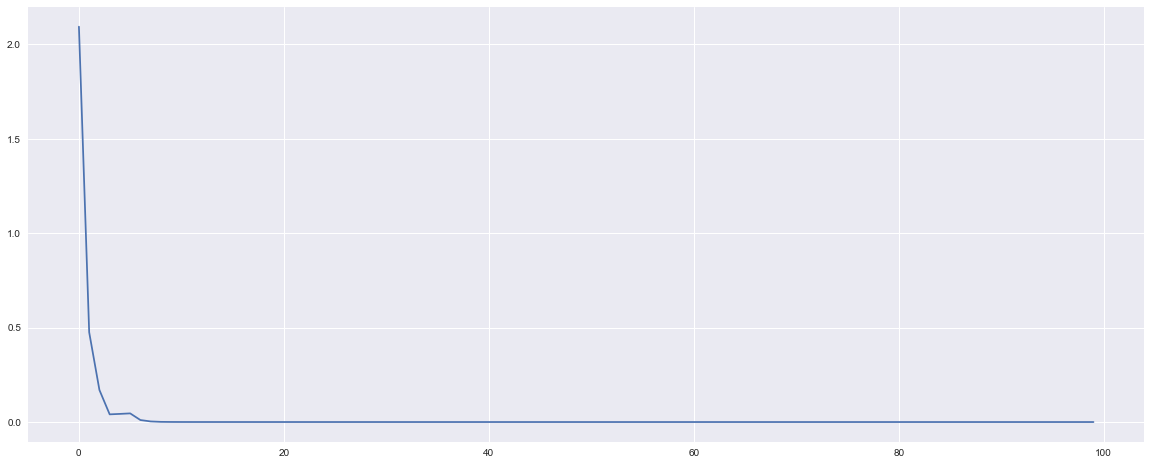

In [57]:
fig, axs = plt.subplots(1,1,figsize=(20,8))
plt.plot(np.arange(NUM_EPOCHS), losses)
plt.show()

### Оценка точности

In [58]:
for i in range(len(np.unique(y_val_tensor))):
    idx = np.argwhere(y_val_tensor==i)[0]
    y_pred = torch.sigmoid(net(X_val_tensor[idx]))
    y = torch.argmax(y_pred, axis=1)
    print(np.unique(Y)[i], len(y[y==i])/len(idx))

1 0.9473684210526315
2 0.88
3 0.9166666666666666
4 0.6842105263157895
5 0.45454545454545453
6 1.0
7 0.6363636363636364
16 0.7777777777777778
17 0.56


In [59]:
with torch.no_grad():
    y_pred = torch.softmax(net(X_val_tensor), 1)
    y = torch.argmax(y_pred, axis=1)
#     print(net(X_val_tensor).shape)
    print(roc_auc_score(y_val_tensor, y_pred, multi_class='ovo'))
    print(f1_score(y_val_tensor, y, average='macro'))

0.9348033884080835
0.7703301768317249
